In [165]:
import pandas as pd
from bs4 import BeautifulSoup
import pymorphy2
import pymystem3
import re
import numpy as np

In [231]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score, StratifiedKFold, validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score

In [229]:
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [167]:
from joblib import Parallel, delayed

In [168]:
def set_answer(predictions, file_name):
    dataframe = pd.DataFrame(predictions, columns=['target'], index=np.arange(200000, 370179))
    dataframe.to_csv('data/'+str(name)+'.csv', index_label='id')

In [169]:
def get_data(processed=False):
    if processed:
        train_data = pd.read_csv('data/train_processed.csv', sep='\t', index_col='id')
        test_data = pd.read_csv('data/test_processed.csv', sep='\t', index_col='id') 
    else:
        train_data = pd.read_csv('data/train.csv', sep='\t', index_col='id')
        test_data = pd.read_csv('data/test.csv', sep='\t', index_col='id') 
    return (train_data, test_data)

In [170]:
## Токенизатор 

morph = pymorphy2.MorphAnalyzer()

def get_lemmas(text):    
    text = BeautifulSoup(text, 'lxml').get_text()       
    lemms = [morph.parse(w)[0].normal_form for w in text.split()]    
    return " ".join([x for x in lemms if re.match('^[0-9a-zа-яё]+(-[0-9a-zа-яё]+)*$', x)])
       
def getVacanciesLemmas(texts):  
    texts = np.array(texts)    
    processed = np.vectorize(get_lemmas, otypes=[str])              
    return processed(texts)

In [204]:
## Функция для красивого вывода наиболее оптимальных параметров обучения
def print_test_results(SearchCV, num=10, top=True):    
    if top :return pd.DataFrame(SearchCV.cv_results_).sort_values(by='mean_test_score', ascending=False).head(num)
    return pd.DataFrame(SearchCV.cv_results_).sort_values(by='mean_test_score', ascending=False).tail(num)

In [172]:
train_data, test_data = get_data()

In [173]:
## при вызове GridSeachCV c n_jobs=-1 не сработает при вызове токенайзера в качестве сторонней функции
##https://github.com/scikit-learn/scikit-learn/issues/5115
##функция так-же падает при попытке вызвать myStem
##поэтому лемматизацию делаем предварительно
%time X = getVacanciesLemmas(train_data['name'][:10000]+' '+train_data['description'][:10000])

Wall time: 8min 29s


In [174]:
pd.DataFrame.to_csv(pd.DataFrame(X), 'data/X_test.csv')

In [175]:
y = train_data.iloc[:10000, -1].values

In [195]:
cv = StratifiedKFold(n_splits=5, random_state=123)

## Оценка SGD Classifier

In [197]:
sgd_clf = Pipeline([
    ('vect', CountVectorizer(min_df=3, max_df=0.9, ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', SGDClassifier(loss='log', random_state=42, fit_intercept=False)),
])

In [198]:
parameters = {    
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'clf__loss': ('hinge', 'log'),    
    'clf__fit_intercept': (True, False)
}

In [199]:
sgd_gs_clf = GridSearchCV(sgd_clf, parameters, n_jobs=-1, cv=cv, scoring='roc_auc')

In [200]:
%%time

sgd_gs_clf.fit(X, y).best_score_

Wall time: 14min 33s


C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9822267027704163

In [205]:
print_test_results(sgd_gs_clf)

C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set r

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf__fit_intercept,param_clf__loss,param_tfidf__norm,param_tfidf__smooth_idf,param_tfidf__use_idf,params,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
31,8.162758,1.096643,0.963472,0.965759,False,hinge,l1,False,False,"{'clf__fit_intercept': False, 'clf__loss': 'hi...",...,0.964094,0.966148,0.965447,0.965449,0.961310,0.966267,0.185102,0.025430,0.001348,0.000440
29,8.088488,1.060008,0.963472,0.965759,False,hinge,l1,True,False,"{'clf__fit_intercept': False, 'clf__loss': 'hi...",...,0.964094,0.966148,0.965447,0.965449,0.961310,0.966267,0.091607,0.012912,0.001348,0.000440
16,8.497129,1.129281,0.963082,0.967162,True,log,l1,True,True,"{'clf__fit_intercept': True, 'clf__loss': 'log...",...,0.965069,0.966971,0.964682,0.966999,0.962078,0.967191,0.498000,0.072037,0.002003,0.000195
40,8.294484,1.103449,0.963065,0.967112,False,log,l1,True,True,"{'clf__fit_intercept': False, 'clf__loss': 'lo...",...,0.964975,0.966937,0.964975,0.966840,0.961900,0.967192,0.162011,0.036693,0.002033,0.000228
18,8.250292,1.072827,0.963024,0.967164,True,log,l1,False,True,"{'clf__fit_intercept': True, 'clf__loss': 'log...",...,0.965031,0.966972,0.964631,0.966990,0.962028,0.967199,0.175390,0.017582,0.002018,0.000197
42,8.423807,1.123869,0.963004,0.967108,False,log,l1,False,True,"{'clf__fit_intercept': False, 'clf__loss': 'lo...",...,0.964900,0.966937,0.964929,0.966835,0.961846,0.967196,0.091602,0.043161,0.002047,0.000225
41,8.210003,1.086233,0.957674,0.959789,False,log,l1,True,False,"{'clf__fit_intercept': False, 'clf__loss': 'lo...",...,0.957970,0.960235,0.959350,0.959400,0.956149,0.960135,0.066003,0.017537,0.001042,0.000350
43,8.262491,1.063218,0.957674,0.959789,False,log,l1,False,False,"{'clf__fit_intercept': False, 'clf__loss': 'lo...",...,0.957970,0.960235,0.959350,0.959400,0.956149,0.960135,0.099065,0.021453,0.001042,0.000350
17,8.932144,1.135086,0.957428,0.959677,True,log,l1,True,False,"{'clf__fit_intercept': True, 'clf__loss': 'log...",...,0.957819,0.959962,0.958335,0.959348,0.956033,0.959976,0.573146,0.081675,0.000861,0.000267
19,8.101353,1.064416,0.957428,0.959677,True,log,l1,False,False,"{'clf__fit_intercept': True, 'clf__loss': 'log...",...,0.957819,0.959962,0.958335,0.959348,0.956033,0.959976,0.167802,0.017472,0.000861,0.000267


## Оценка Forest

In [277]:
frst_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(random_state=42, n_estimators=1750, min_samples_leaf=1, min_samples_split=2
                                                   ,max_depth=30, criterion='entropy'))
])

In [278]:
parameters = {    
    'vect__max_df': (1.0, 0.9, 0.8),
    'vect__min_df': (1, 3, 10),
    'vect__ngram_range': [(1,1), (1,2)],
    'tfidf__norm': (None, 'l2'),
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),    
    #'clf__n_estimators': (100, 1000, 1750),
    #'clf__criterion': ('entropy', 'gini'),
    #'clf__max_depth': (5, 12, 20, 30),
    #'clf__min_samples_split' : (2, 10, 20),
    #'clf__min_samples_leaf' : (1, 10, 50),
}

In [279]:
frst_gs_clf = RandomizedSearchCV(frst_clf, parameters, n_jobs=-1, cv=cv, scoring='roc_auc', random_state=42)

In [280]:
%%time

frst_gs_clf.fit(X, y).best_score_

Wall time: 39min 41s


0.9825781313678661

In [282]:
print_test_results(frst_gs_clf).T

C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\unifam.OFFICE\AppData\Local\Continuum\anaconda2\envs\p36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set r

,4,2,7,8,5,9,6,0,1,3
mean_fit_time,101.58,117.135,105.688,136.606,128.656,126.294,127.706,158.484,323.634,308.303
mean_score_time,2.18458,2.13293,3.19454,2.86532,2.60287,2.3654,2.51729,4.71368,10.1039,10.9604
mean_test_score,0.982578,0.982351,0.982123,0.981674,0.981673,0.981618,0.981189,0.980284,0.978602,0.97826
mean_train_score,0.999574,0.999761,0.999248,0.999401,0.999401,0.999421,0.999716,0.999421,0.998448,0.999032
param_tfidf__norm,None,l2,None,None,None,None,l2,l2,None,l2
param_tfidf__smooth_idf,False,True,False,False,True,True,False,False,True,True
param_tfidf__use_idf,False,True,False,False,True,False,False,True,False,False
param_vect__max_df,1,0.9,0.9,0.8,0.8,1,0.9,0.9,1,0.9
param_vect__min_df,3,10,10,1,1,1,1,3,1,1
param_vect__ngram_range,"(1, 1)","(1, 1)","(1, 2)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 2)","(1, 2)","(1, 2)"


In [ ]:
depths = range(1, 50, 10)
estimators = range(100, 2000, 100)
_, forest_estimators_test_scores = validation_curve(frst_clf, X, y, param_name='clf__n_estimators', param_range=estimators, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

_, forest_max_depth_test_scores = validation_curve(frst_clf, X, y, param_name='clf__max_depth', param_range=depths, 
                 scoring='roc_auc', cv=cv, n_jobs=-1)

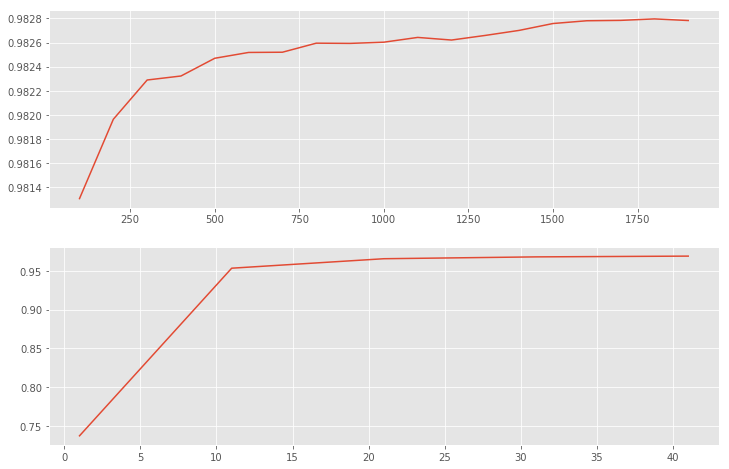

In [244]:
f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(estimators, forest_estimators_test_scores.mean(axis=1))
ax2.plot(depths, forest_max_depth_test_scores.mean(axis=1))

## Оценка логистической регрессии

In [ ]:
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(random_state=42, solver='saga')),
])

In [ ]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__max_df': (1, 0.9, 0.8),
              'tfidf__use_idf': (True, False),
              'tfidf__smooth_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
              'clf__max_iter': (5, 10, 50)
              'clf__C': (0.1, 1.0, 10.0, 50.0)
              
}

In [ ]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, scoring='roc_auc')

In [ ]:
%%time
gs_clf.fit(X[:400], y[:400]).best_score_

In [ ]:
fr = pd.DataFrame(gs_clf.cv_results_)

In [ ]:
fr.columns

In [ ]:
fr.sort_values(by='mean_test_score', ascending=False).head()

In [ ]:
mystem.close()